In [6]:
import os
import sys
import numpy as np
from librosa import load
from librosa.display import specshow, waveshow
from IPython.display import Audio
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from loudness_encoder import loudness

c:\Users\nicho\Desktop\DWST\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nicho\Desktop\DWST\venv\lib\site-packages\nnAudio\Spectrogram.py:4: Warning: importing Spectrogram subpackage will be deprecated soon. You should import the feature extractor from the feature subpackage. See actual documentation.
  warnings.warn(


In [4]:
y,sr = load('../test_audio/mallet_acoustic_074-072-050.wav', sr=None)

C:\Users\nicho\AppData\Local\Temp\ipykernel_11752\38001232.py:1: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  waveshow(y,sr)


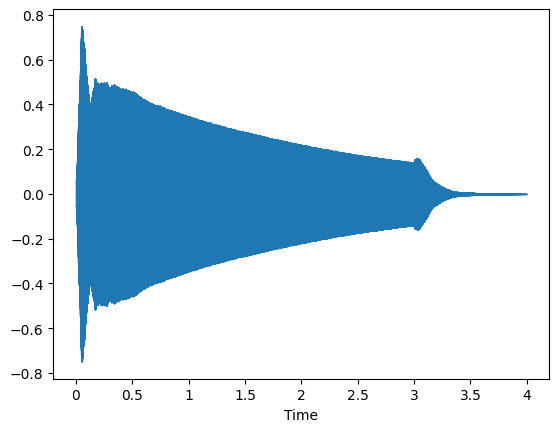

In [8]:
waveshow(y,sr)

In [10]:
loud = loudness(y, sr)

STFT kernels created, time used = 0.1619 seconds
(126,)


In [11]:
import matplotlib.pyplot as plt

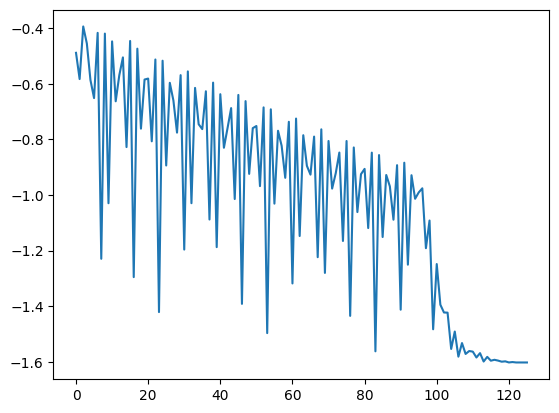

In [15]:
plt.plot(loud)

In [16]:
import pyloudnorm as pyln

In [17]:
meter = pyln.Meter(sr) # create BS.1770 meter
loudness = meter.integrated_loudness(y)

In [19]:
loudness

-14.176402023586997

In [5]:
import librosa
import numpy as np

# Load the audio data and compute the STFT
y, sr = librosa.load('../test_audio/mallet_acoustic_074-072-050.wav', sr=None)
stft = librosa.stft(y)
print(stft.shape)
# Calculate the frequencies of the STFT bins
frequencies = librosa.fft_frequencies(sr=sr, n_fft=stft.shape[0])
print(frequencies.shape)
# Calculate loudness using librosa's perceptual_weighting function
loudness = librosa.perceptual_weighting(np.square(stft), frequencies=frequencies)

# Convert loudness from dB to a linear scale
loudness = np.power(10.0, loudness / 20.0)

# Compute the mean over frequency bins
loudness_mean = np.mean(loudness, axis=0)

# Apply log compression with a small offset to prevent overflow
eps = 1e-5
loudness_mean = np.log(loudness_mean + eps)

# Scale the loud


(1025, 126)
(513,)


c:\Users\nicho\Desktop\DWST\venv\lib\site-packages\librosa\core\convert.py:1332: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)
c:\Users\nicho\Desktop\DWST\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  return f(*args, **kwargs)


ValueError: operands could not be broadcast together with shapes (513,1) (1025,126) 

In [4]:
import numpy as np
from librosa import stft, load, fft_frequencies, perceptual_weighting, db_to_amplitude

In [6]:
y, sr = load('../test_audio/mallet_acoustic_074-072-050.wav',sr=None)

n_fft = 512
hop_size = 64
padding = 'center'

spec = stft(y, n_fft=n_fft, hop_length=hop_size, center=True)
print(spec.shape)
spec = np.square(spec)

fft_freq = fft_frequencies(sr, n_fft)

spec_weighted = perceptual_weighting(spec, fft_freq)
spec_weighted = db_to_amplitude(spec_weighted)

mean = np.mean(spec_weighted, axis=0)
offset = 1e-5

compressed_mean = np.log10(mean+offset)

(257, 1001)


C:\Users\nicho\AppData\Local\Temp\ipykernel_10000\3409841493.py:11: FutureWarning: Pass sr=16000, n_fft=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_freq = fft_frequencies(sr, n_fft)
c:\Users\nicho\Desktop\DWST\venv\lib\site-packages\librosa\core\convert.py:1332: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)
c:\Users\nicho\Desktop\DWST\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  return f(*args, **kwargs)


In [28]:
compressed_mean.shape

(1001,)

In [31]:
compressed_mean

-0.2524200749775846

In [1]:
from torch import stft

c:\Users\nicho\Desktop\DWST\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
stft